In [ ]:
from src.fforma import FFORMA
from sklearn.decomposition import PCA
from src.meta_learner import MetaLearnerNN
from src.meta_results_r_data import prepare_fforma_data

from ESRNN.m4_data import prepare_m4_data, seas_dict
from ESRNN.utils_evaluation import evaluate_prediction_owa

from src.utils import (
    evaluate_forecasts,
    freqs
)
from src.benchmarks import FactorQuantileRegressionAveraging

import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pickle

from statsmodels.regression.quantile_regression import QuantReg

from src.metrics.metrics import smape, mape
from src.benchmarks import evaluate_panel

In [ ]:
data = prepare_fforma_data(directory='data', dataset_name=None, kind='TOURISM')
#dataset_name=None for all data

In [ ]:
X_train = data['preds_train_df']
y_train = data['y_train_df']
X_test = data['preds_test_df']
y_test = data['y_test_df']

In [ ]:
unique_ids = X_train['unique_id'].unique()
smape_list = []
y_hat_list = []
u_id_list = []
ds_list = []
for u_id in unique_ids:
    x_id = X_train[X_train['unique_id']==u_id].drop(columns=['unique_id','ds']).values
    x_test = X_test[X_test['unique_id']==u_id].drop(columns=['unique_id','ds']).values
    y_id = y_train[y_train['unique_id']==u_id]['y'].values
    y_test_id = y_test[y_test['unique_id']==u_id]['y'].values

    pca_model = PCA(n_components=1).fit(x_id)
    X = pca_model.transform(x_id)
    X = np.hstack([X, np.ones((len(X),1))])

    reg = QuantReg(y_id, X).fit(0.5)

    x_test_pca = pca_model.transform(x_test)
    x_test_pca = np.hstack([x_test_pca, np.ones((len(x_test_pca),1))])
    y_hat = reg.predict(x_test_pca)

    my_smape=200*np.mean(np.abs(y_hat-y_test_id)/(np.abs(y_hat)+np.abs(y_test_id)))
    smape_list.append(my_smape)
    y_hat_list += y_hat.tolist()
    u_id_list += [u_id]*len(y_hat)
    ds_list += list(range(len(y_hat)))
    
df_hat = pd.DataFrame(list(zip(u_id_list, ds_list, y_hat_list)), 
               columns =['unique_id', 'ds', 'y_hat']) 
    
np.mean(smape_list)

In [ ]:
evaluate_panel(y_test, df_hat, smape)

In [ ]:
fqra = FactorQuantileRegressionAveraging(n_components=1, tau=0.5)

In [ ]:
fqra.fit(X_train, y_train, X_test, y_test)

In [ ]:
fqra.test_min_smape

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_data(m=100, n=20, sigma=5, density=0.2):
    "Generates data matrix X and observations Y."
    np.random.seed(1)
    beta_star = 0.01 * np.random.randn(n) + 1/n
    #idxs = np.random.choice(range(n), int((1-density)*n), replace=False)
    #for idx in idxs:
    #    beta_star[idx] = 0
    X = np.random.randn(m,n)
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y, beta_star

m = 100
n = 20
sigma = 5
density = 0.2

X, Y, beta_s = generate_data(m, n, sigma)
X_train = X[:50, :]
Y_train = Y[:50]
X_test = X[50:, :]
Y_test = Y[50:]

average_weights = 1/n * np.ones(n)

def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer(beta):
    return cp.norm1(beta-average_weights)

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

In [3]:
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
#beta_mu = cp.Parameter()
problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, lambd)))

lambd_values = np.logspace(-2, 3, 50)
#beta_mu_value = 1/n
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    #beta_mu.value = beta_mu_value
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

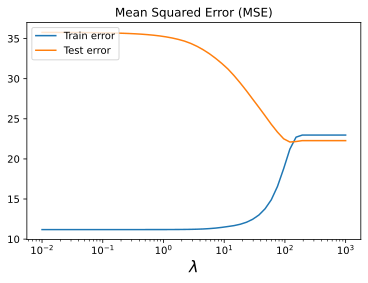

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()

plot_train_test_errors(train_errors, test_errors, lambd_values)

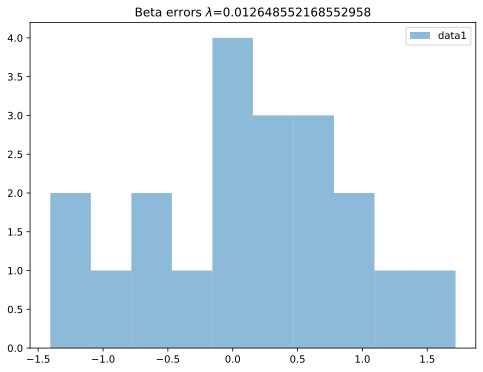

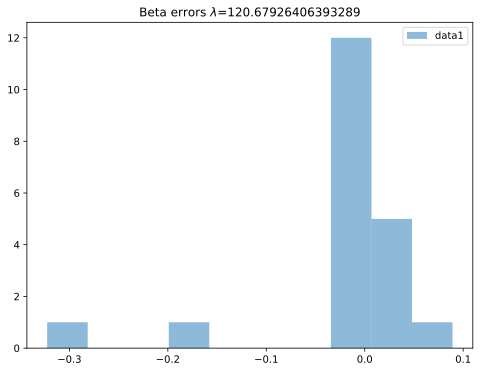

In [5]:
def plot_beta_errors(beta_s, beta_values, lambd_values, idx):
    plt.figure(figsize=(8,6))
    beta_errors = beta_s - beta_values[idx]
    lambd_value = lambd_values[idx]
    plt.hist(beta_errors, bins=10, alpha=0.5, label="data1")
    plt.title(r"Beta errors $\lambda$={}".format(lambd_value))
    plt.legend(loc='upper right')

plot_beta_errors(beta_s, beta_values, lambd_values, 1)
plot_beta_errors(beta_s, beta_values, lambd_values, 40)

In [ ]:
beta_s - beta_values[49]